In [1]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
import json

import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from random import shuffle
import pandas as pd
import random

import keras
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.layers import Input, Dense, Lambda
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw

import os
import sys
sys.path.insert(0, '../')
from scripts import build_vae, decode_smiles, generate_structures, my_colors, MoleculeVAE

def generate_structures(vae, smi, char_to_index, limit=1e4, write=False):
    """
    Quick and Dirty: 
    Use this VAE, this smiles string, and this char_to_index
    dictionary to randomly generate structures at random temperatures
    """
    rdkit_mols = []
    temps = []
    iterations = []
    iteration = limit_counter = 0
    while True:
        iteration += 1
        limit_counter += 1
        t = random.random()*2
        candidate = decode_smiles(vae, smi, char_to_index, temp=t).split(" ")[0]
        try:
            sampled = Chem.MolFromSmiles(candidate)
            cation = Chem.AddHs(sampled)
            Chem.EmbedMolecule(cation, Chem.ETKDG())
            Chem.UFFOptimizeMolecule(cation)
            cation = Chem.RemoveHs(cation)
            candidate = Chem.MolToSmiles(cation)
            if candidate not in rdkit_mols:
                temps.append(t)
                iterations.append(iteration)
                rdkit_mols.append(candidate) 
                limit_counter = 0
                df = pd.DataFrame([rdkit_mols,temps,iterations]).T
                df.columns = ['smiles', 'temperature', 'iteration']
                print(df)
        except:
            pass
        if limit_counter > limit:
            break
        if write:
            df = pd.DataFrame([rdkit_mols,temps,iterations]).T
            df.columns = ['smiles', 'temperature', 'iteration']
            pd.DataFrame.to_csv(df, path_or_buf='{}.csv'.format(write), index=False)
    return df

vae_models = ['Bootstrap_250k_Cation_1.h5', 'Bootstrap_1Mil_Cation_1.h5',
    '1Mil_GDB17.h5', '1Mil_GDB17_split_500k.h5', '1Mil_GDB17_split_500k_cation_500k.h5']

def pad_smiles(smiles_string, smile_max_length):
     if len(smiles_string) < smile_max_length:
            return smiles_string + " " * (smile_max_length - len(smiles_string))
        
def one_hot(smi, char_to_index):
    test_smi = smi
    smile_max_length=51
    char_set = set(char_to_index.keys())
    test_smi = pad_smiles(test_smi, smile_max_length)
    Z = np.zeros((1, smile_max_length, len(list(char_set))), dtype=np.bool)
    for t, char in enumerate(test_smi):
        Z[0, t, char_to_index[char]] = 1
    return Z

from numpy import *
from numpy.linalg import norm

def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    # work around from https://github.com/llSourcell/How-to-Generate-Music-Demo/issues/4
    a = np.log(a) / temperature 
    dist = np.exp(a)/np.sum(np.exp(a)) 
    choices = range(len(a)) 
    return np.random.choice(choices, p=dist)

def slerp(p0, p1, t):
        omega = arccos(dot(p0/norm(p0), p1/norm(p1)))
        so = sin(omega)
        return sin((1.0-t)*omega) / so * p0 + sin(t*omega)/so * p1

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


**cation stuff**

In [2]:
#for getting cation data
properties = ['density', 'cpt', 'viscosity', 'thermal_conductivity',
              'melting_point']
props = properties
devmodel = salty.aggregate_data(props, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation']
cations = devmodel.Data['smiles_string'].drop_duplicates()
cations = cations.reset_index(drop=True)

In [3]:
categories = []
for cation in cations:
    category = salty.assign_category(pd.DataFrame([salty.check_name(cation)],
                                                  columns=['name-cation']))['category'][0]
    categories.append(category)
coldic = {}
tab = my_colors()
for cat in pd.DataFrame(categories)[0].unique():
    coldic[cat] = next(tab)

ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 1
['1-phenyl-3,5-dimethyl-2-pentylpyrazolium']
ILs labeled as other: 1
['1-phenyl-3,5-dimethyl-2-hexylpyrazolium']
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 1
['N,N-dimethylformamide']
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 0
[]
ILs labeled as other: 1
['N-me

In [4]:
weights_file = "../data/{}".format(vae_models[-1])
f = open("../data/1mil_GDB17.json","r")
char_to_index = json.loads(f.read())
chemvae = MoleculeVAE()
char_set = set(char_to_index.keys())
chemvae.load(char_set, weights_file)

In [5]:
z = []
for smi in cations:
    z_i = chemvae.encoder.predict(one_hot(smi, char_to_index))
    z.append(z_i[0])
z = np.array(z)
pca = PCA(n_components=2)
pca.fit_transform(z)

array([[ 1.22050250e+00,  1.44420743e-01],
       [ 1.11021113e+00, -1.39187783e-01],
       [ 1.04687905e+00, -1.09527325e-02],
       [ 8.19570482e-01, -3.15703958e-01],
       [ 4.22607884e-02, -6.23318613e-01],
       [-1.17161179e+00, -8.06220651e-01],
       [-1.17879736e+00, -9.56338286e-01],
       [-7.95397937e-01, -2.49137893e-01],
       [ 6.01974726e-01,  7.33354867e-01],
       [ 1.19534481e+00, -6.82047457e-02],
       [ 2.95893967e-01, -4.82120872e-01],
       [ 1.13354301e+00,  2.24570066e-01],
       [ 1.28887928e+00,  1.23355351e-01],
       [ 5.75652361e-01, -3.86466116e-01],
       [-1.24477640e-01, -4.47356433e-01],
       [ 3.17640066e-01,  7.72957265e-01],
       [ 2.69504860e-02,  1.02599192e+00],
       [-2.47304067e-01, -3.96729738e-01],
       [ 2.28629231e+00,  3.03365678e-01],
       [ 5.82442939e-01, -1.76981211e-01],
       [ 1.15181172e+00, -3.11860263e-01],
       [ 1.53507221e+00,  7.00782239e-01],
       [-4.38731104e-01, -5.09028196e-01],
       [-3.

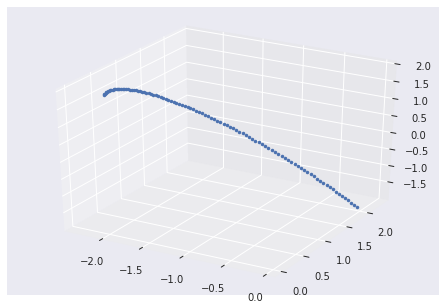

In [6]:
# example of the SLERP
if __name__ == '__main__':
    pA = array([-2.0, 0.0, 2.0])
    pB = array([0.0, 2.0, -2.0])

    ps = array([slerp(pA, pB, t) for t in arange(0.0, 1.0, 0.01)])

    from pylab import *
    from mpl_toolkits.mplot3d import Axes3D
    f = figure()
    ax = Axes3D(f)
    ax.plot3D(ps[:,0], ps[:,1], ps[:,2], '.')
    show()

In [72]:
cat1 = z[181]
cat2 = z[242]

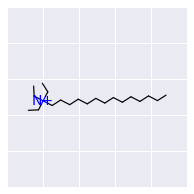

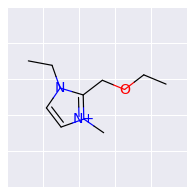

In [74]:
im1 = Draw.MolToMPL(Chem.MolFromSmiles(cations[181]), size=(100,100))
im2 = Draw.MolToMPL(Chem.MolFromSmiles(cations[242]), size=(100,100))

In [84]:
# we can interpolate between these molecules...
ps = array([slerp(cat1, cat2, t) for t in arange(0.0, 1.0, 0.1)])
pca.transform(ps)

array([[-1.1553673 ,  0.5685917 ],
       [-1.0391078 ,  0.57513607],
       [-0.9204312 ,  0.5682979 ],
       [-0.80208266,  0.5482339 ],
       [-0.6868001 ,  0.5154095 ],
       [-0.5772498 ,  0.47058302],
       [-0.47596672,  0.4147923 ],
       [-0.38529333,  0.34932745],
       [-0.3073274 ,  0.2757027 ],
       [-0.24387273,  0.19562192]], dtype=float32)

181
242


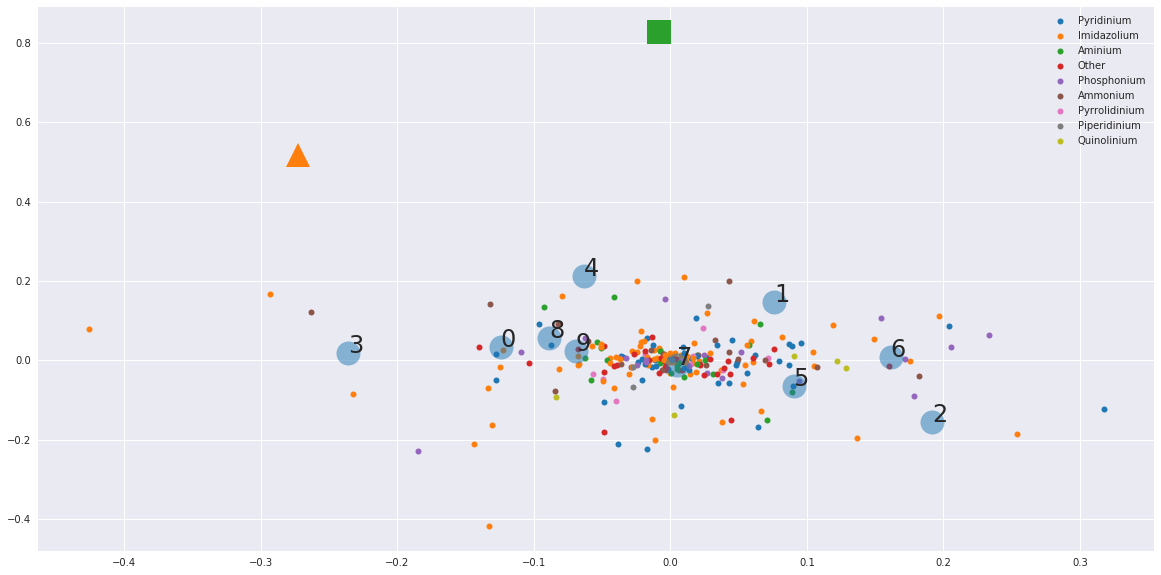

In [85]:
from collections import OrderedDict
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
for i in range(len(categories)):
    x = np.sum(np.dot(pca.components_[0,i],z[i,:]))
    y = np.sum(np.dot(pca.components_[1,i],z[i,:]))
    if y >0.4:
        print(i)
    if i == 181:
        ax1.plot(x, y, linestyle='', marker='s', 
                 color=coldic[categories[i]], markersize=24, label=categories[i])
    if i == 242:
        ax1.plot(x, y, linestyle='', marker='^', 
                 color=coldic[categories[i]], markersize=24, label=categories[i])
    ax1.plot(x, y, linestyle='', marker='.', 
             color=coldic[categories[i]], markersize=12, label=categories[i])

# for viewing the PCs of the embeded inerpolations
for i in range(ps.shape[0]):
    x = np.sum(np.dot(pca.components_[0,i],ps[i,:]))
    y = np.sum(np.dot(pca.components_[1,i],ps[i,:]))
    ax1.plot(x, y,
            linestyle='', marker='o', color='tab:blue', markersize=24, alpha=0.5)
    ax1.text(x, y, '{}'.format(i), fontsize=24)
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

Now lets generate structures between those two points...

In [86]:
def interpolate_structures(vae, ps, char_to_index, limit=1e4, write=False, temp=0.5):
    """
    Quick and Dirty: 
    Use this VAE, these interpolations of embeded z's, and this char_to_index
    dictionary to randomly generate structures at temp
    """
    rdkit_mols = []
    temps = []
    iterations = []
    iteration = limit_counter = 0
    df = pd.DataFrame()
    for p in ps:
        while True:
            iteration += 1
            limit_counter += 1
            t = temp
            candidate = decode_latent(chemvae, p.reshape(1,292), char_to_index, temp=t)
            try:
                sampled = Chem.MolFromSmiles(candidate)
                cation = Chem.AddHs(sampled)
                Chem.EmbedMolecule(cation, Chem.ETKDG())
                Chem.UFFOptimizeMolecule(cation)
                cation = Chem.RemoveHs(cation)
                candidate = Chem.MolToSmiles(cation)
                if candidate not in rdkit_mols:
                    temps.append(t)
                    iterations.append(iteration)
                    rdkit_mols.append(candidate) 
                    limit_counter = 0
                    df = pd.DataFrame([rdkit_mols,temps,iterations]).T
                    df.columns = ['smiles', 'temperature', 'iteration']
                    print(df)
                    print(t)
                    break
            except:
                pass
            if limit_counter > limit:
                break
        if write:
            df = pd.DataFrame([rdkit_mols,temps,iterations]).T
            df.columns = ['smiles', 'temperature', 'iteration']
            pd.DataFrame.to_csv(df, path_or_buf='{}.csv'.format(write), index=False)
    return df
    
def decode_latent(vae, z, char_to_index, temp=0.5, smile_max_length=51):
    """
    vae: variational autoencoder to encode/decode input
    smi: smiles string to encode
    temp: temperature at which to perform sampling
    """
    char_list = list(char_to_index.keys())
    index_to_char = dict((i, c) for i, c in enumerate(char_list))
    string = ""
    for i in vae.decoder.predict(z):
        for j in i:
            index = sample(j, temperature=temp)
            string += index_to_char[index]
    return string

In [87]:
df = interpolate_structures(chemvae, ps, char_to_index, limit=1e4, temp=0.25)

                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25         1
0.25
                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25         1
1  CCCCCCCCCCCCCC[C+](CC)(CC)CC        0.25        72
0.25
                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25         1
1  CCCCCCCCCCCCCC[C+](CC)(CC)CC        0.25        72
2   CCCCCCCCCCCCCC[C+](C)(CC)CC        0.25        73
0.25
                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25         1
1  CCCCCCCCCCCCCC[C+](CC)(CC)CC        0.25        72
2   CCCCCCCCCCCCCC[C+](C)(CC)CC        0.25        73
3   CCCCCCCCCCCCCC[N+](O)(CC)CC        0.25       195
0.25
                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25         1
1  CCCCCCCCCCCCCC[C+](CC)(CC)CC        0.25        72
2   CCCCCCCCCCCCCC[C+](C)(CC)CC        0.25        73
3   CCCC

In [107]:
df.to_csv('../data/cation_interpolation.csv', index=False)

In [109]:
pd.DataFrame(cations).to_csv('../data/cations.csv', index=False)

In [103]:
ms = [i for i in df['smiles']]
ms.insert(0, cations[181])
ms.insert(-1, cations[242])

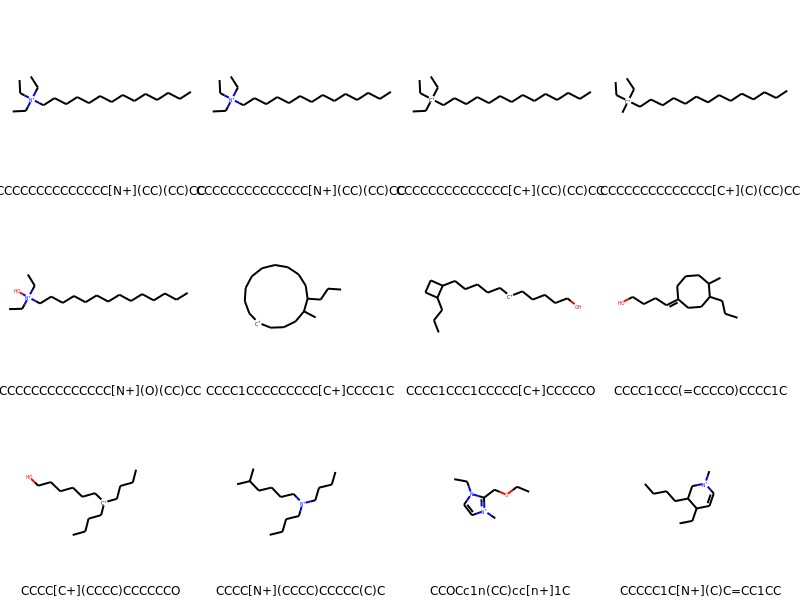

In [105]:
ms = [Chem.MolFromSmiles(smi) for smi in ms]
Draw.MolsToGridImage(ms[:],molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])

In [69]:
### From a run performed earlier... ###
ms = [cations[0], 'CCCC[C+]1C=CC(C)=C1C', 'CCCC[C+]1C=CC(CC)=C1', cations[2]]
ms = [Chem.MolFromSmiles(smi) for smi in ms]

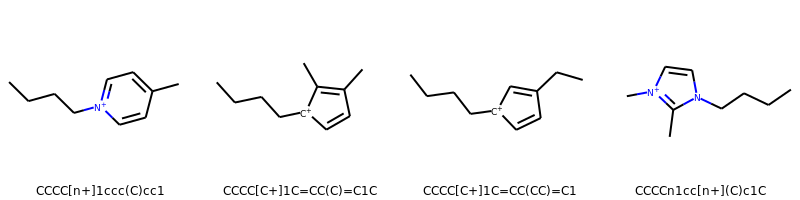

In [70]:
Draw.MolsToGridImage(ms[:4],molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:4]])

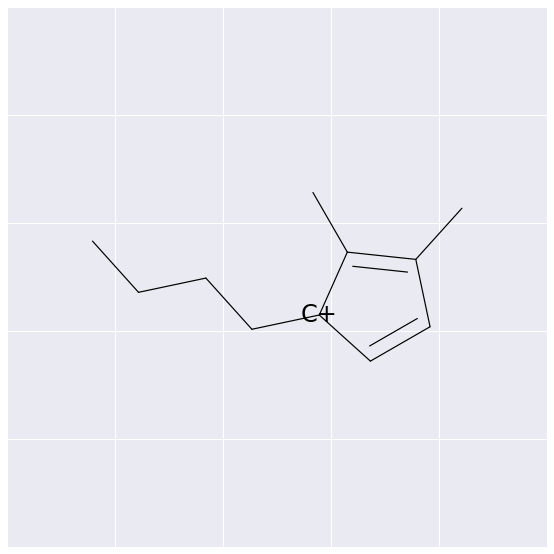

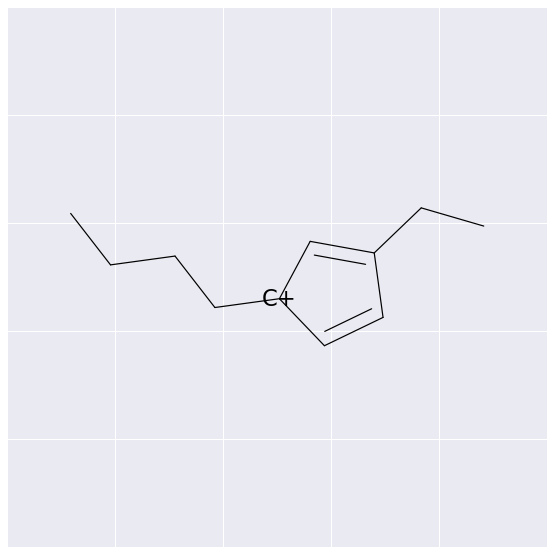

In [202]:
for smi in df['smiles']:
    img = Draw.MolToMPL(Chem.MolFromSmiles(smi))

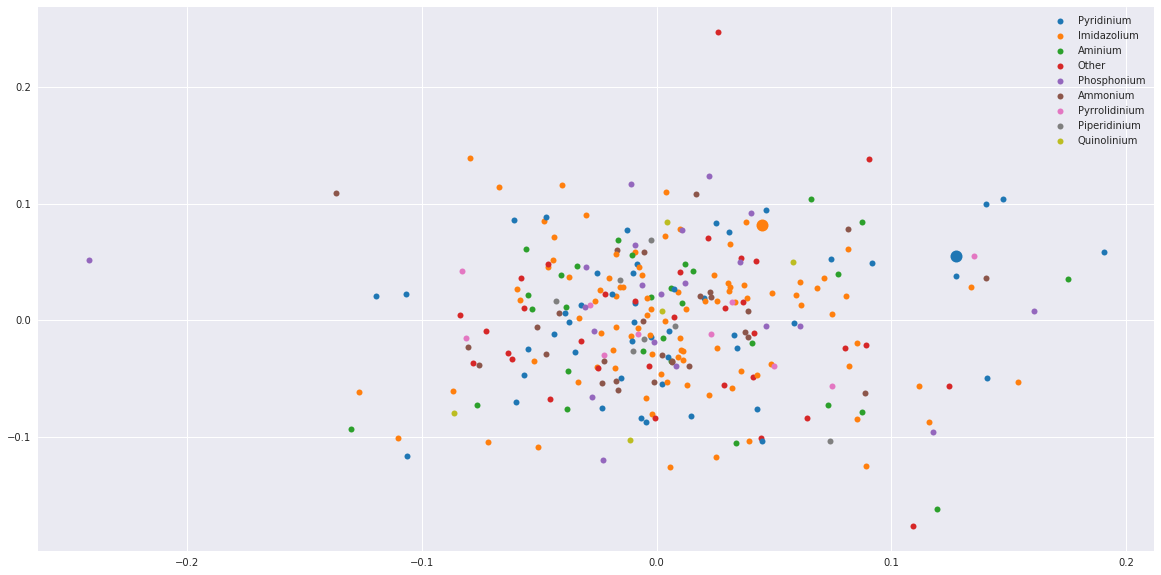

In [21]:
from collections import OrderedDict
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
for i in range(len(types)):
    if i == 0:
        ax1.plot(pca.components_[0,i], pca.components_[1,i],
                linestyle='', marker='.', color=coldic[types[i]], markersize=24, label=types[i])
    if i == 2:
        ax1.plot(pca.components_[0,i], pca.components_[1,i],
                linestyle='', marker='.', color=coldic[types[i]], markersize=24, label=types[i])
    ax1.plot(pca.components_[0,i], pca.components_[1,i],
            linestyle='', marker='.', color=coldic[types[i]], markersize=12, label=types[i])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [10]:
z.shape

(1, 292)

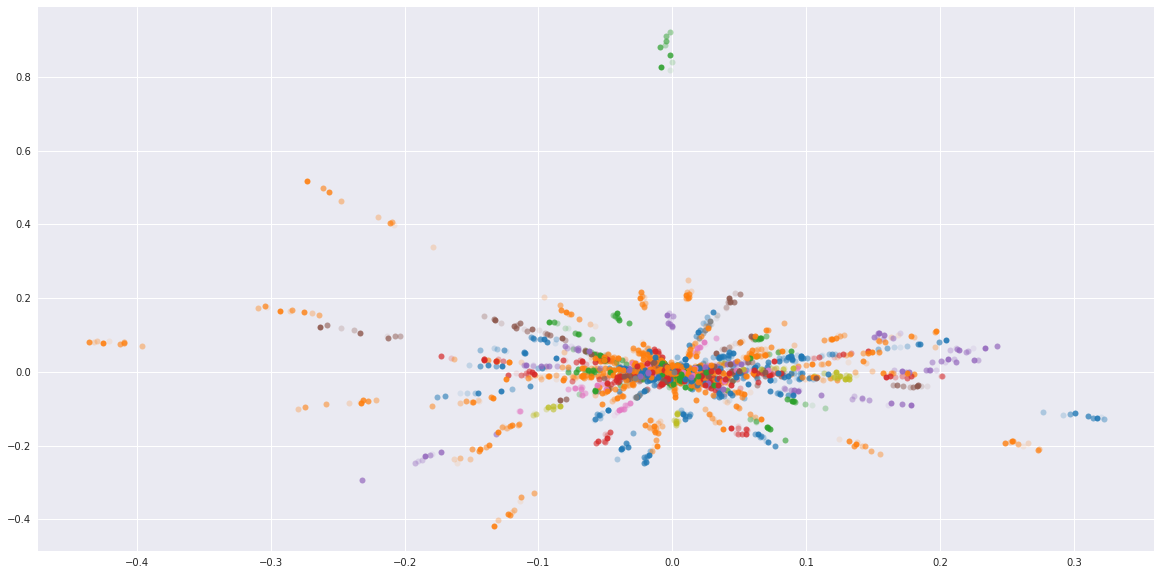

In [13]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
for peter in range(10):
    z = []
    for smi in cations:
        z_i = chemvae.encoder.predict(one_hot(smi, char_to_index))
        z.append(z_i[0])
    z = np.array(z)
    pca = PCA(n_components=2)
    pca.fit_transform(z)

    for i in range(len(categories)):
        ax1.plot(np.sum(np.dot(pca.components_[0,i],z[i,:])), 
             np.sum(np.dot(pca.components_[1,i],z[i,:])),
            linestyle='', marker='.', color=coldic[categories[i]], markersize=12, label=categories[i], alpha=peter/10)

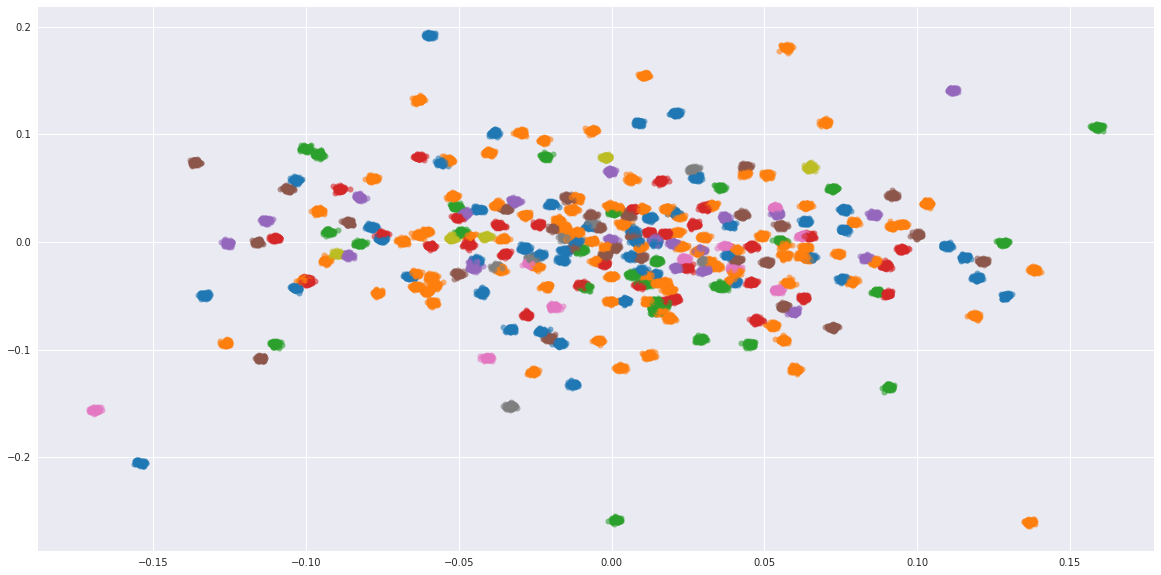

In [161]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
for peter in range(100):
    z_s = []
    for smi in cations:
        z = chemvae.encoder.predict(one_hot(smi))
        z_s.append(z[0])
    z_s = np.array(z_s)
    pca = PCA(n_components=2)
    pca.fit_transform(z_s)

    for i in range(len(types)):
        ax1.plot(pca.components_[0,i], pca.components_[1,i],
                linestyle='', marker='.', color=coldic[types[i]], markersize=12, alpha=0.6)

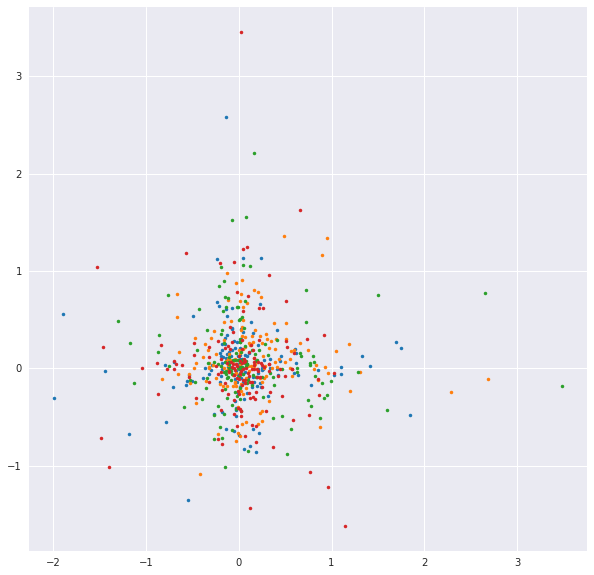

In [19]:
fig = plt.figure(figsize=(10,10))
x = z
ax1 = fig.add_subplot(111)
tab = my_colors()
add = np.zeros((x.shape))
split = int(pca.components_[0].shape[0]/2)
for i, pc in enumerate(pca.components_[:4]):
    add = add + (x*pc)
    color = next(tab)
    ax1.plot(np.sum((x*pc),axis=0)[:split],np.sum((x*pc),axis=0)[split:],
           linestyle='', marker='.', color=color, alpha=1, label='PC{}'.format(i+1))

In [36]:
decode_smiles(chemvae.autoencoder, smi, char_to_index)

'CCCC1n+]1Ccc(cCC)C                                 '

In [5]:
autoencoder = build_vae()
smi = 'CCCC[n+]1ccc(cc1)C'
autoencoder.load_weights("../data/{}".format(vae_models[-1]))

In [6]:
df1 = pd.read_csv('../scripts/vae_1_structures.csv')
df2 = pd.read_csv('../scripts/vae_2_structures.csv')
df3 = pd.read_csv('../scripts/vae_3_structures.csv')
df4 = pd.read_csv('../scripts/vae_4_structures.csv')
df5 = pd.read_csv('../scripts/vae_5_structures.csv')
dfs = [df1, df2, df3, df4, df5]

Text(0.5,0,'Sanitized Samples')

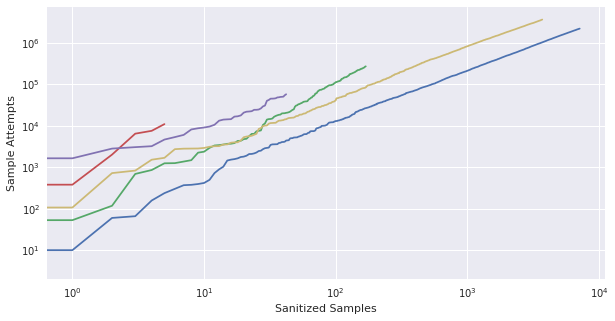

In [7]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
for index, df in enumerate(dfs):
    df['iteration'].plot(label='{}'.format(index+1), ax=ax, loglog=True)
ax.set_ylabel('Sample Attempts')
ax.set_xlabel('Sanitized Samples')
# plt.legend()

Text(-0.6,-0.5,'Temperature')

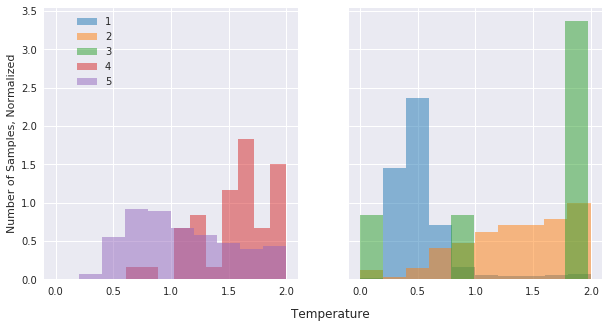

In [8]:
# fig = plt.figure(figsize=(10,10))
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212, sharey=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
tab = my_colors()
for index, df in enumerate(dfs):
    if index < 3:
        df['temperature'].hist(alpha=0.5, label='{}'.format(index+1), normed=True, ax=ax2, color=next(tab))
    else:
        df['temperature'].hist(alpha=0.5, label='{}'.format(index+1), normed=True, ax=ax1, color=next(tab))
h1, l1 = ax2.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(-0.9,1))
ax1.set_ylabel('Number of Samples, Normalized')
plt.text(-0.6,-0.5,'Temperature',size=12)


In [98]:
from rdkit.Chem import MACCSkeys

In [111]:
seed = Chem.MolFromSmiles(smi)
for df in dfs:
    t_similarities=[]
    for mol in df['smiles']:
        ms = [Chem.MolFromSmiles(smi), Chem.MolFromSmiles(mol)]
#         fps = [MACCSkeys.GenMACCSKeys(x) for x in ms]
        fps = [FingerprintMols.FingerprintMol(x) for x in ms]
        t_similarities.append(DataStructs.FingerprintSimilarity(fps[0],fps[1]))
    df['tanimoto'] = t_similarities

/Users/wab665/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(-0.6,-0.5,'Temperature')

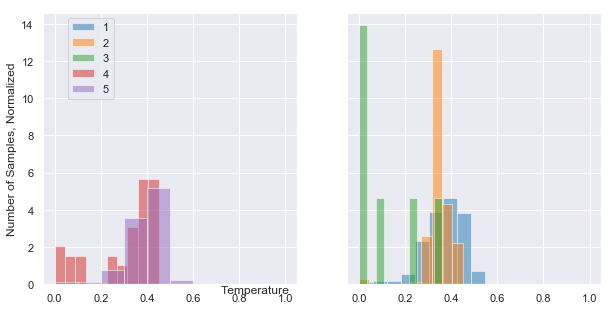

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
tab = my_colors()
for index, df in enumerate(dfs):
    if index < 3:
        df['tanimoto'].hist(alpha=0.5, label='{}'.format(index+1), normed=True, ax=ax2, color=next(tab))
    else:
        df['tanimoto'].hist(alpha=0.5, label='{}'.format(index+1), normed=True, ax=ax1, color=next(tab))
h1, l1 = ax2.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(-0.9,1))
ax1.set_ylabel('Number of Samples, Normalized')
plt.text(-0.6,-0.5,'Temperature',size=12)


/Users/wab665/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(-0.6,-0.5,'Temperature')

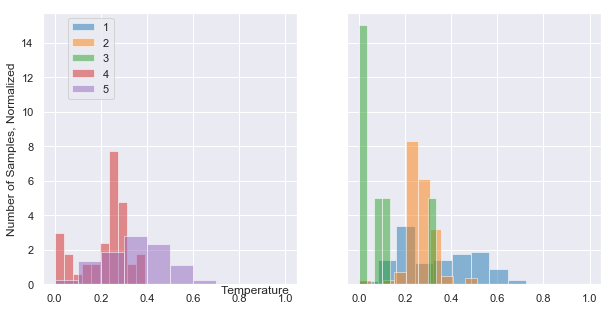

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
tab = my_colors()
for index, df in enumerate(dfs):
    if index < 3:
        df['maccs'].hist(alpha=0.5, label='{}'.format(index+1), normed=True, ax=ax2, color=next(tab))
    else:
        df['maccs'].hist(alpha=0.5, label='{}'.format(index+1), normed=True, ax=ax1, color=next(tab))
h1, l1 = ax2.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(-0.9,1))
ax1.set_ylabel('Number of Samples, Normalized')
plt.text(-0.6,-0.5,'Temperature',size=12)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12be96f28>]],
      dtype=object)

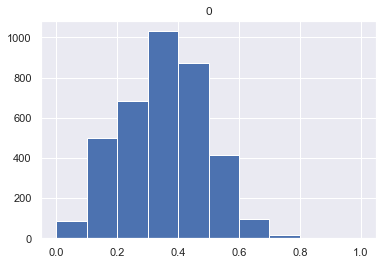

In [108]:
pd.DataFrame(t_similarities).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12be2c908>]],
      dtype=object)

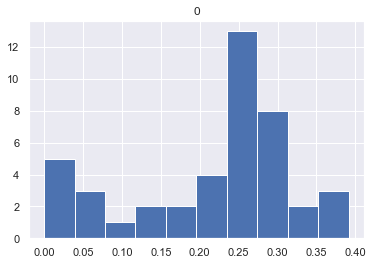

In [106]:
pd.DataFrame(t_similarities).hist()

In [101]:
df3

,smiles,temperature,iteration
0,C,1.964667,41
1,CCF,1.906305,381
2,CC1(C)CC=NN=NC=NOCCON1,0.982750,2027
3,CC,1.974641,6488
4,CCCCCCCCCCCCCCCCCCCCCC,0.000016,7600
5,N,1.885615,11039


CCCNCC


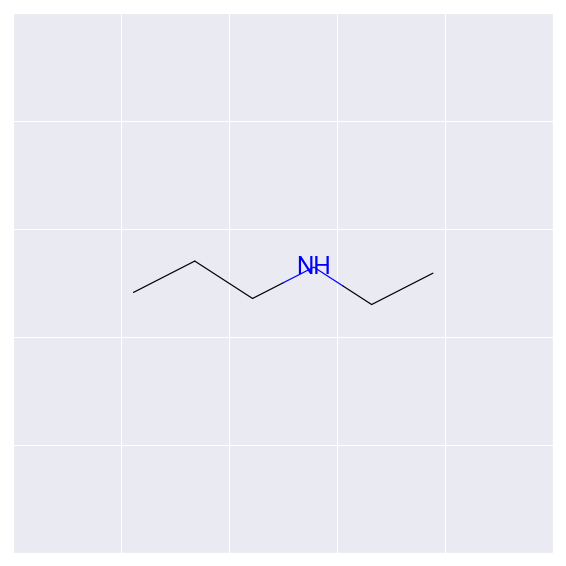

In [74]:
smi = df5.loc[df5['temperature'].sort_values().index]['smiles'][303]
mol = Chem.MolFromSmiles(smi)
print(smi)
img = Draw.MolToMPL(mol)

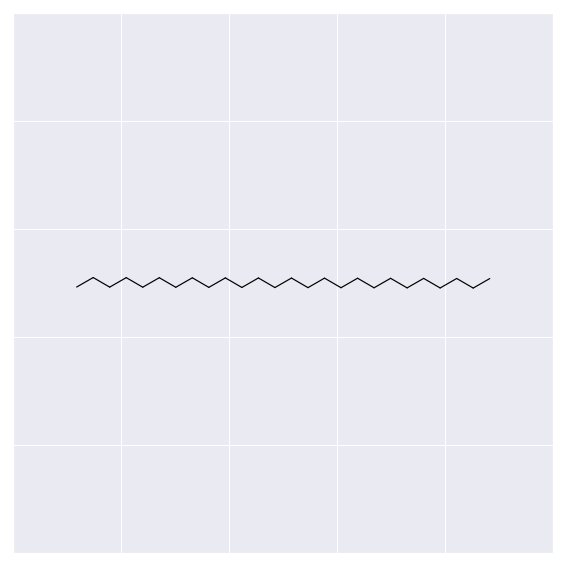

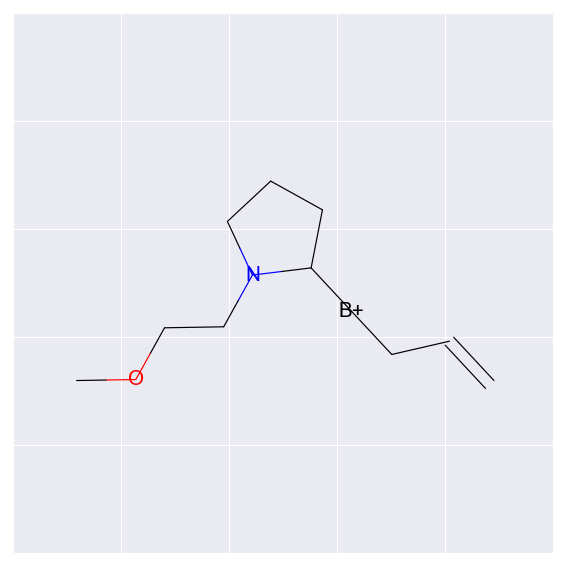

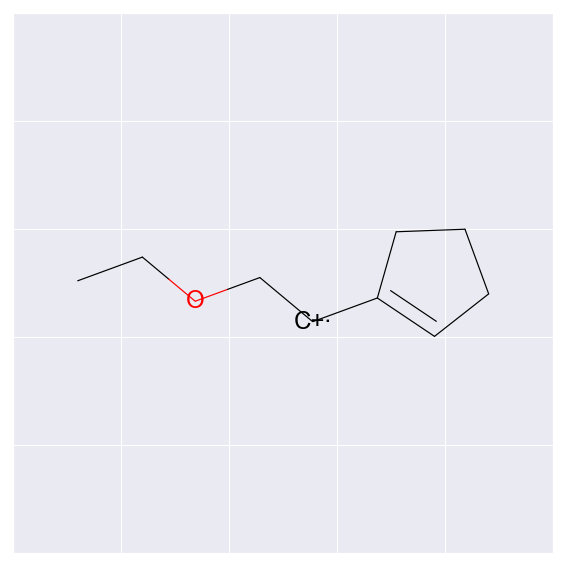

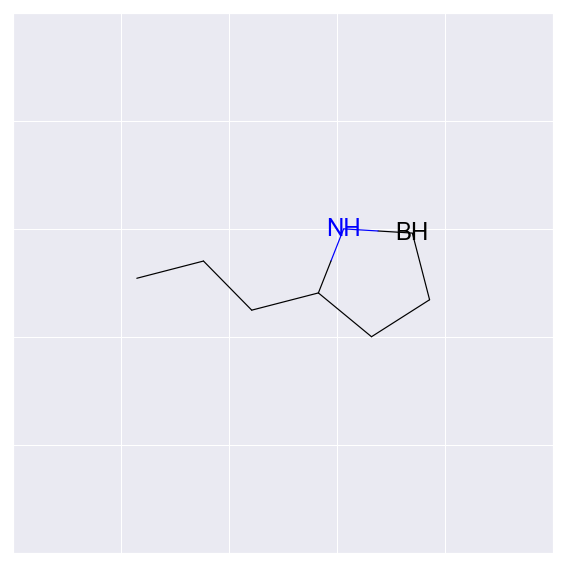

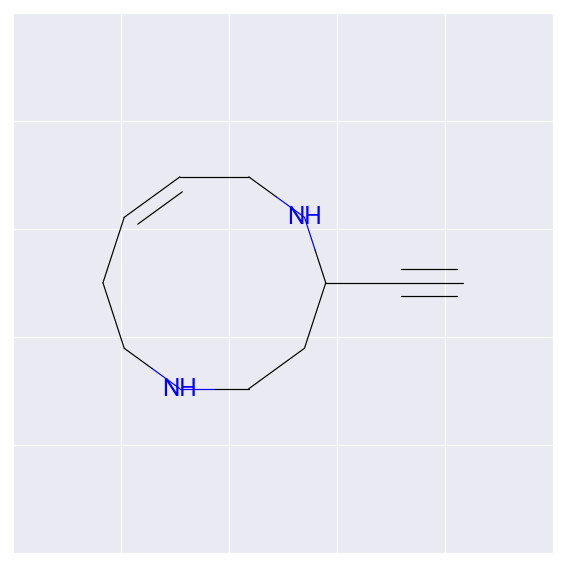

In [90]:
for i in range(0,5):
    smi = df5.loc[df5['temperature'].sort_values().index[-i]]['smiles']
    sampled = Chem.MolFromSmiles(smi)
    Draw.MolToMPL(sampled)